# Data Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

## I. Data Description

The dataset consists of 3000 bird images equally divided into 3 classes. The classes represent three different bird species which are the Erithacus Rubecu-la (the European robin), the Periparus Ater (the Coal Tit), and the Pica Pica (the Eurasian magpie). 

In [2]:
classes = ['Periparus_ater', 'Pica_pica', 'Erithacus_Rubecula']

## II. Data Cleaning:

1. The dataset contains some unusable pictures (e.g., duplicate images or images with no birds visible). Those images were manually filtered and removed before any data preprocessing was applied. The cleaned dataset was saved in ./Brids_cleaned

In [3]:
my_data_dir = './Birds_cleaned'

In [4]:
from PIL import Image

dataset = {}
for bird_class in classes:
    file_path = '{}/{}'.format(my_data_dir, bird_class)
    files = []
    for image_filename in os.listdir(file_path):
        if '.jpg' not in image_filename:
            continue
        img = Image.open('{}/{}'.format(file_path, image_filename))
        files.append(img)
    dataset[bird_class] = files


2. The original images come in a wide range of sizes; however, the majority of heights and widths are at least 600 pixels.


In [5]:
def get_mean_dims(df):
    dim1 = []
    dim2 = []
    bird_classes = []
    for bird_class in list(df.keys()):
        for image in df[bird_class]:
            d1,d2 = image.size
            dim1.append(d1)
            dim2.append(d2)
            bird_classes.append(bird_class)
    print('mean dimensions across all classes: ', np.mean(dim1), ' x ', np.mean(dim2))
    q1, q3 = np.quantile(a=dim1, q=[0.25, 0.75])
    print('widths 25% quantile: ', q1, ',   widths 75% quantile: ', q3)
    q1, q3 = np.quantile(a=dim2, q=[0.25, 0.75])
    print('heights 25% quantile:', q1, ',   heights 75% quantile:', q3)
    return dim1, dim2, bird_classes

dim1, dim2, bird_classes = get_mean_dims(dataset)

mean dimensions across all classes:  941.6474991493706  x  787.079278666213
widths 25% quantile:  898.5 ,   widths 75% quantile:  1024.0
heights 25% quantile: 683.0 ,   heights 75% quantile: 923.5


[Text(0.5, 1.0, 'Images dimesions')]

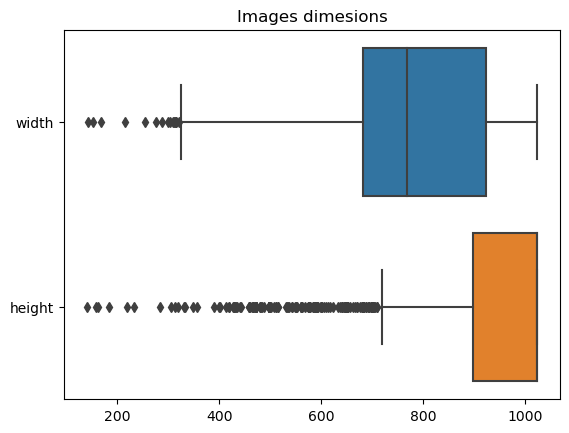

In [6]:
df_ = pd.DataFrame(data={'width': dim2, 'height': dim1})
sns.boxplot(data=df_, orient='h').set(title='Images dimesions')

To avoid the loss of quality and feature resolution when the images are resized, **all images with dimensions less then 600 pixels were discarded.** The remaining images are saved in the ./images directory where the rest of data preprocessing will take place.

In [7]:
IMAGES_DIR = './images'

In [ ]:
def remove_small_images():
    if not os.path.exists('images'):
        os.makedirs('images')
    else:
        os.system('rm -rf images')
        os.makedirs('images')

    for bird_class in classes:
        file_path = '{}/{}'.format(my_data_dir, bird_class)
        files = []
        for image_filename in os.listdir(file_path):
            if '.jpg' not in image_filename:
                continue
            origin_path = '{}/{}'.format(file_path, image_filename)
            img = Image.open(origin_path)
            h, w = img.size
            if(w >= 600 and h >= 600):
                dist_path = '{}/{}'.format(IMAGES_DIR, image_filename)
                os.system("cp {} {}".format(origin_path.replace(" ", "\ "), dist_path.replace(" ", "")))
                
remove_small_images()

In [ ]:
print('The remaining images ammount to {}% of the original data.'.format((len(os.listdir(IMAGES_DIR)) / 3000) * 100))

## III. Data Tagging

The photos were carefully tagged using [ReNom-Tag version v1.3b3](https://www.renom.jp/packages/renomtag/index.html). The tags are in TensorFlow Pascal VOC format.
All tags were exported in XML format. The following script cleans out the XML files to remove any unknown characters and saves the outpout to ./images/cleaned

In [26]:
ORIGINAL_TAGS_DIR = './tags'               # the original exported xml tags
TAGS_DIR = '{}/cleaned'.format(IMAGES_DIR) # the target directory for clean tags

In [28]:
import glob
import os
import shutil

if not os.path.exists(TAGS_DIR):
    os.makedirs(TAGS_DIR)
else:
    os.system('rm -rf {}'.format(TAGS_DIR))
    os.makedirs(TAGS_DIR)

for file in glob.glob('{}/*.xml'.format(ORIGINAL_TAGS_DIR)):   
    with open(file, 'r') as f:
        with open('{}/%s'.format(TAGS_DIR) %os.path.basename(file), 'w') as f1:
            for line in f:
                f1.write(line.rstrip().replace(" ", ""))

os.system('rsync -a {}/ {}/'.format(TAGS_DIR, IMAGES_DIR))

0

## IV. Data Split

The data is partitioned into 90% training and 10% testing (for evaluation).
The splitted subsets are saved into ./images/train and ./images/test, respectively.

In [31]:
!python partition_dataset.py -x -i IMAGES_DIR -r 0.1

ValueError: filedescriptor out of range in select()

In [34]:
TRAIN_IMGS_DIR = '{}/train'.format(IMAGES_DIR)
TEST_IMGS_DIR = '{}/test'.format(IMAGES_DIR)

## V. Data Augumentation

The training dataset is imbalanced accross classes.

In [70]:
from xml.dom.minidom import parseString

def count_boxes():
    count = {}
    images = {}
    for filename in os.listdir(TRAIN_IMGS_DIR):
        if('.xml' in filename):
            file = open(TRAIN_IMGS_DIR + '/' + filename,'r')
            data = file.read()
            file.close()
            dom = parseString(data)
            bird_class = dom.getElementsByTagName('name')[0].firstChild.nodeValue
            bndbxs = len(dom.getElementsByTagName('bndbox'))
            
            if bird_class not in count:
                count[bird_class] = 0
            count[bird_class] += bndbxs
            
            if(bndbxs > 0):
                if bird_class not in images:
                    images[bird_class] = 0
                images[bird_class] += 1
    return count, images

boxes_count, images_count = count_boxes()
print('Number of boxes per class: ', boxes_count)
print('Number of images per class: ', images_count)

Number of boxes per class:  {'PicaPica': 861, 'PeriparusAter': 791, 'ErithacusRubecula': 779}
Number of images per class:  {'PicaPica': 778, 'PeriparusAter': 775, 'ErithacusRubecula': 778}


The number of tags per class varies for each of the three classes. To eliminate the imbalance and to introduce more data variation, data augmentation techniques are applied to the training dataset. The images are augmented by adding random brightness and contrast jitters. 
<br/>
<br/>
Since almost all pictures are taken in daylight, altering the brightness for some images simulates taking images at different light conditions thus adding more variation to the data. After augmenta-tion. The target tags per class is 1000.

In [71]:
TARGET_COUNT = 1000

From each class, 50 photos were manually chosen to apply augmentation on them. Each of the 50 photos contain exactly 1 bird to make it easier to follow the number of added tags.

In [72]:
AUGMENTATION_IMGS_DIR = './augmentation'

In [73]:
def clean_names(class_name):
    # Clean the image names for the newly generated images
    # Output names follow the format: {original_name}_aug_{number of augmented photo}.jpg
    
    count = 1
    path = '{}/{}/output'.format(AUGMENTATION_IMGS_DIR, class_name)
    for img_name in os.listdir(path):
        if '.jpg' not in img_name or '_original_' not in img_name:
            continue
        original_name = img_name.split('.jpg')[0].split('_original_')[1]
        new_name = original_name + '_aug_' + str(count) + '.jpg'
        count += 1
        os.rename('{}/{}'.format(path, img_name), '{}/{}'.format(path, new_name))

Since both applied augmentation filters are label preserving, the original tags are copied and renamed to the newly generated images.

In [74]:
def get_tags(class_name):
    # Copy original tag XML file and rename it to the new name
    
    path = '{}/{}/output'.format(AUGMENTATION_IMGS_DIR, class_name)
    for img_name in os.listdir(path):
        if '.jpg' not in img_name:
            continue
        original_name = img_name.split('_aug_')[0]
        new_name = img_name.split('.jpg')[0]
        tag_path = '{}/{}.xml'.format(TAGS_DIR, original_name)
        target_path = '{}/{}.xml'.format(path, new_name)
        
        with open(tag_path, 'r') as f:
            with open(target_path, 'w') as f1:
                for line in f:
                    f1.write(line.rstrip().replace(original_name, new_name))

In [88]:
import Augmentor

def format_class_name(name):
    return name.replace('_', ' ').title().replace(' ', '')

def generatePtotos():
    for class_name in classes:
        path = '{}/{}'.format(AUGMENTATION_IMGS_DIR, class_name)
        print('find . -name "' + path + '/.DS_Store" -delete')
        os.system('find . -name "' + path + '/.DS_Store" -delete')
        pipeline = Augmentor.Pipeline(path)
        pipeline.random_brightness(probability=1, min_factor=0.6, max_factor=1.4)
        pipeline.random_contrast(probability=1, min_factor=0.6, max_factor=1.4)

        pipeline.sample(TARGET_COUNT - boxes_count[format_class_name(class_name)])
        cleanNames(class_name)
        get_tags(class_name)

In [79]:
def move_files_to_train():
    # move all generated files to the training directory
    for class_name in classes:
        path = '{}/{}/output'.format(AUGMENTATION_IMGS_DIR, class_name)
        for file in os.listdir(path):
            s.system("cp {}/{} {}/{}".format(path, file, TRAIN_IMGS_DIR, file))
    print('Done.')

In [89]:
generatePtotos()
move_files_to_train()

find . -name "./augmentation/Periparus_ater/.DS_Store" -delete
Initialised with 50 image(s) found.
Output directory set to ./augmentation/Periparus_ater/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE158C3C250>:  46


AttributeError: 'OSError' object has no attribute 'message'